In [1]:
import os
os.chdir("..")
assert 'PromptDataExtract' in os.getcwd()

In [2]:
# Load settings
from backend import sett, postgres
from backend.utils.frame import Frame
sett.load_settings()
postgres.load_settings()

Load OK: settings.yaml


In [3]:
# Connect to database
db = postgres.connect('polylet')

NOTE  -- postgres_ Connected to PostGres DB: polylet (took 0.056 s)


In [4]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.style.use("PromptDataExtraction/notebooks/matplotlib.mplstyle")
except:
    try:
        plt.style.use("~/matplotlib.mplstyle")
    except: pass

In [5]:
def execute(sql, **kwargs) -> pd.DataFrame:
    """ Query the database using raw sql.
        Return a pandas dataframe containing the results.
    """
    results = postgres.raw_sql(sql, kwargs)
    if not results:
        return None
    return pd.DataFrame.from_records(results, columns=results[0]._fields)

In [6]:
def timings(seconds : int):
    # Total time on the pipeline.
    print(str(datetime.timedelta(seconds = seconds)))
    print(f"{seconds / 3600 :.2f} hours")

In [7]:
method = postgres.raw_sql("""
    Select * From extraction_methods 
    Where dataset = 'data1' and name like '%-gpt35-similar-full';
""")
method

[Row(name='lcst-gpt35-similar-full', dataset='data1', model='gpt-3.5-turbo', api='openai', para_subset='lcst_ner_full', extraction_info={'user': 'sonakshi', 'shot_selector': 'similar', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 0.5, 'max_api_retries': 1, 'api_request_delay': 0.01, 'temperature': 0.001, 'prompt': "Extract all lower critical solution temperature values in JSONL format with 'material', 'property', 'value', 'condition' columns.", 'shot_nrecords': 2, 'shot_keywords': 'false'}, id=181, date_added=datetime.datetime(2023, 10, 23, 14, 38, 35, 774371, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=72000)))),
 Row(name='tm-gpt35-similar-full', dataset='data1', model='gpt-3.5-turbo', api='openai', para_subset='tm_ner_full', extraction_info={'user': 'sonakshi', 'shot_selector': 'similar', 'n_shots': 1, 'api_retry_delay': 60, 'delay_multiplier': 0.5, 'max_api_retries': 1, 'api_request_delay': 0.01, 'temperature': 0.001, 'prompt': "Extract all melting temp

In [8]:
# Number of materials extracted.
execute("""
      SELECT count(*) FROM extracted_materials em
      WHERE em.method_id >= 175 and em.method_id <= 202
      """)

,count
0,161923


In [9]:
# Number of properties extracted.
execute("""
        SELECT em.name, count(*) FROM extracted_properties ep
        JOIN extraction_methods em ON em.id = ep.method_id
        WHERE ep.method_id >= 175 and ep.method_id <= 202
        group by em.name, ep.method_id;
        """)

,name,count
0,bandgap-gpt35-similar-full,15097
1,cs-gpt35-similar-full,18194
2,dc-gpt35-similar-full,13507
3,eab-gpt35-similar-full,15414
4,hardness-gpt35-similar-full,16075
5,ionic_cond-gpt35-similar-full,12366
6,ri-gpt35-similar-full,67
7,tc-gpt35-similar-full,14561
8,td-gpt35-similar-full,16248
9,tg-gpt35-similar-full,15626


### Tg extracted data

In [8]:
# Number of materials extracted.
execute("""
      SELECT count(*) FROM extracted_materials em
      WHERE em.method_id = 180
      """)

,count
0,26808


In [9]:
# Number of properties extracted.
execute("""
        SELECT count(*) FROM extracted_properties ep
        WHERE ep.method_id = 180
        --group by ep.method_id;
        """)

,count
0,30764


In [10]:
tg_data = execute("""
        SELECT em.para_id, ep.numeric_value FROM extracted_properties ep
        JOIN extracted_materials em ON em.id = ep.material_id
        WHERE ep.method_id = 180
        --group by ep.method_id;
        """)

tg_data

,para_id,numeric_value
0,9142141,-135.0
1,9142145,58.8
2,9142145,137.4
3,9142421,-123.0
4,9142421,-145.0
...,...,...
30759,7761419,140.0
30760,7761448,80.0
30761,7761448,94.0
30762,7761448,93.0


In [11]:
print(min(tg_data['numeric_value']))
print(max(tg_data['numeric_value']))

-2000.0
162829.0


In [12]:
tg_data[tg_data['numeric_value']== 91000.0]

,para_id,numeric_value
19121,8085709,91000.0


In [13]:
tg_data[tg_data['para_id']== 8224143]

,para_id,numeric_value
25191,8224143,36137.0
25192,8224143,54103.0
25193,8224143,74898.0
25194,8224143,68640.0
25195,8224143,76005.0
25196,8224143,130710.0
25197,8224143,156320.0


In [10]:
sorted(tg_data['numeric_value'], reverse=True)

[162829.0,
 156320.0,
 130710.0,
 126000.0,
 112000.0,
 91000.0,
 90000.0,
 83000.0,
 80800.0,
 76005.0,
 74898.0,
 71000.0,
 68640.0,
 67600.0,
 63000.0,
 57200.0,
 54103.0,
 53500.0,
 51000.0,
 50000.0,
 50000.0,
 44000.0,
 43000.0,
 41000.0,
 37000.0,
 36137.0,
 35000.0,
 32000.0,
 32000.0,
 30000.0,
 29000.0,
 26000.0,
 25285.0,
 25000.0,
 23000.0,
 20000.0,
 20000.0,
 19000.0,
 16900.0,
 15000.0,
 14000.0,
 12800.0,
 11505.0,
 10000.0,
 10000.0,
 9300.0,
 9000.0,
 8700.0,
 8119.999999999999,
 7508.0,
 6800.0,
 6690.0,
 6417.0,
 6017.0,
 6000.0,
 5643.0,
 5600.0,
 5539.0,
 5435.0,
 5400.0,
 5350.0,
 4200.0,
 4000.0,
 3696.0,
 3610.0,
 3550.0,
 3300.0,
 3277.0,
 3250.0,
 3217.0,
 3000.0,
 2924.0,
 2921.0,
 2800.0,
 2710.0,
 2642.0,
 2610.0,
 2525.0,
 2514.4500000000003,
 2380.0,
 2380.0,
 2340.0,
 2323.0,
 2300.0,
 2256.0,
 2200.0,
 2193.5,
 2193.5,
 2193.5,
 2021.0,
 1990.0,
 1910.0,
 1900.0,
 1858.6000000000001,
 1858.0,
 1850.0,
 1790.0,
 1790.0,
 1710.0,
 1640.0,
 1589.0,
 1549.

In [12]:
plt.hist(tg_data['numeric_value'], bins=10000, color='blue')
plt.xlim(-2000, 2000)

(-2000.0, 2000.0)

In [2]:
#Total time so far
!grep "All done." filtered_paras/full-corpus/gpt/*full.log | awk -F '(took | s)' '{sum += $2} END {print sum}'

902329


In [11]:
timings(902329)

10 days, 10:38:49
250.65 hours


In [8]:
td_data  = execute(
  """
  SELECT em.para_id, count(*) FROM extracted_properties ep
  JOIN extracted_materials em ON em.id = ep.material_id
  where ep.method_id = 202
  group by em.para_id
"""
)

(array([[0.000e+00, 0.000e+00, 0.000e+00, 4.770e+02, 0.000e+00, 0.000e+00,
         3.000e+00, 0.000e+00, 1.489e+03, 3.364e+03],
        [5.333e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]]),
 array([1.0000000e+00, 9.4982370e+05, 1.8996464e+06, 2.8494691e+06,
        3.7992918e+06, 4.7491145e+06, 5.6989372e+06, 6.6487599e+06,
        7.5985826e+06, 8.5484053e+06, 9.4982280e+06]),
 <a list of 2 BarContainer objects>)

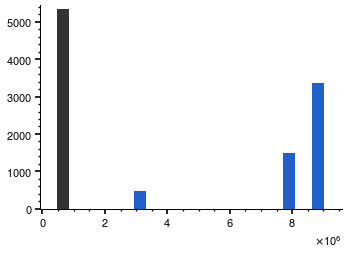

In [10]:
plt.hist(td_data)

In [15]:
set(td_data['count'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 26, 28, 36, 40}

In [14]:
td_data[td_data['count'] == 40]

,para_id,count
3042,8873511,40


In [21]:
td_data[td_data['count'] == 5].shape

(300, 2)